In [3]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import pickle

In [4]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
data_import = pd.read_csv('Daily_attendance.csv')

In [7]:
all_years_test = data_import
all_years_test.set_index('Full_Date', inplace=True)

In [8]:
all_years_test.index = pd.to_datetime(all_years_test.index)
ds = all_years_test.index.to_series()
all_years_test['YEAR'] = ds.dt.year
all_years_test['MONTH'] = ds.dt.month
all_years_test['DAY_OF_WEEK'] = ds.dt.dayofweek
all_years_test['DAY'] = ds.dt.day

In [9]:
all_years_test.drop(columns=['snow_1h'], inplace=True)
all_years_test["federal_holiday_flag"] = all_years_test["federal_holiday_flag"].astype(int)
all_years_test["school_holiday_flag"] = all_years_test["school_holiday_flag"].astype(int)

In [10]:
all_years_test.isna().sum()

value                   0
temp                    0
temp_min                0
temp_max                0
pressure                0
humidity                0
wind_speed              0
wind_gust               3
rain_1h                 0
federal_holiday_flag    0
school_holiday_flag     0
YEAR                    0
MONTH                   0
DAY_OF_WEEK             0
DAY                     0
dtype: int64

In [11]:
all_years_test['wind_gust'].fillna((all_years_test['wind_gust'].mean()), inplace=True)

In [12]:
# df_standard_scale = StandardScaler()
# x_standard = df_standard_scale.fit_transform(all_years_test)

In [13]:
mask = np.random.rand(len(all_years_test)) < 0.8
df_train = all_years_test[mask]
df_test = all_years_test[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=362
Testing data set length=98


In [14]:
expr = """value ~ DAY  + DAY_OF_WEEK + MONTH + YEAR + temp + temp_min + temp_max + pressure + humidity + wind_speed + wind_gust + rain_1h + federal_holiday_flag + school_holiday_flag"""

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(all_years_test.loc[:, all_years_test.columns != 'value'], all_years_test['value'], test_size =0.2, random_state = 42)

In [16]:
# y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
# y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
X_test = df_test.drop(columns=["value"])
X_test = dmatrices(expr, X_test, return_type='dataframe')
X_test

PatsyError: Error evaluating factor: NameError: name 'value' is not defined
    value ~ DAY  + DAY_OF_WEEK + MONTH + YEAR + temp + temp_min + temp_max + pressure + humidity + wind_speed + wind_gust + rain_1h + federal_holiday_flag + school_holiday_flag
    ^^^^^

In [ ]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  367
Model:                            GLM   Df Residuals:                      352
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22768.
Date:                Tue, 19 Apr 2022   Deviance:                       42270.
Time:                        11:47:59   Pearson chi2:                 4.04e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              395.2382 

In [ ]:
print(poisson_training_results.mu)

[ 800.74069941  604.10696293  607.33824215  803.00396138  830.77327059
  777.84758391  896.97374355  885.28886498 1068.74948302  723.8658725
  616.1245534   703.74870031  877.09602166  800.72563412  746.58632527
  869.84878023  930.58122825  767.43753525 1185.86424804  979.06870553
  808.75177749  684.82666549  895.96106601 1200.05741224 1180.18950185
 1219.33908702 1206.27043636 1494.12441974 1572.8869189  1402.30906626
  682.16587843 1568.02019501  863.20946238  887.88536011 1652.15160309
 1430.04956812 1350.3386675  1291.54975594  947.79447377  654.84533133
 1705.72052052 2104.45219585 1465.66068797 1396.17006267  830.8328837
 1113.63792323 1582.08918577 1156.0604909  1559.40262246 1618.19705772
 1579.40453841 1900.61614793 1982.83332312 1915.77304918 1509.82994659
 1358.22590867 1892.66191745 2056.01668307 1857.97673639 1795.79065209
 2691.73921686 1770.82641233 1904.8121671  1974.20759783 2041.739464
 1984.46565412 2159.61006601 2098.69792177 2193.32152757 2423.44927971
 2469.4931

In [ ]:
mu_glm = poisson_training_results.mu

In [ ]:
df_train['Value_LAMBDA'] = mu_glm

C:\Users\huawe\AppData\Local\Temp/ipykernel_18436/3183006973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Value_LAMBDA'] = mu_glm


In [ ]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)

C:\Users\huawe\AppData\Local\Temp/ipykernel_18436/3108702462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)


In [ ]:
ols_expr = """AUX_OLS_DEP ~ Value_LAMBDA - 1"""

In [ ]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [ ]:
print(aux_olsr_results.params)

Value_LAMBDA    0.0689
dtype: float64


In [ ]:
aux_olsr_results.tvalues

Value_LAMBDA    9.820795
dtype: float64

In [ ]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
# save the model to disk
filename = 'volume_prediction.sav'
pickle.dump(nb2_training_results, open(filename, 'wb'))

In [ ]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  367
Model:                            GLM   Df Residuals:                      352
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2763.8
Date:                Tue, 19 Apr 2022   Deviance:                       641.17
Time:                        11:48:00   Pearson chi2:                     541.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.7931
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              359.0354 

In [ ]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

ValueError: shapes (93,14) and (15,) not aligned: 14 (dim 1) != 15 (dim 0)

In [ ]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame["mean"])

Full_Date
2019-05-04     668.580460
2019-05-05     898.454518
2019-05-10     560.127238
2019-05-14     550.661714
2019-05-16     763.573903
                 ...     
2021-10-14    1534.160127
2021-10-16    1401.953943
2021-10-21    1309.748299
2021-10-24    1417.601329
2021-10-28    1396.342737
Name: mean, Length: 93, dtype: float64


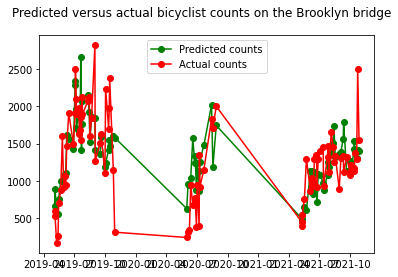

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

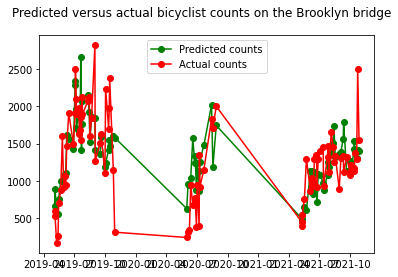

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

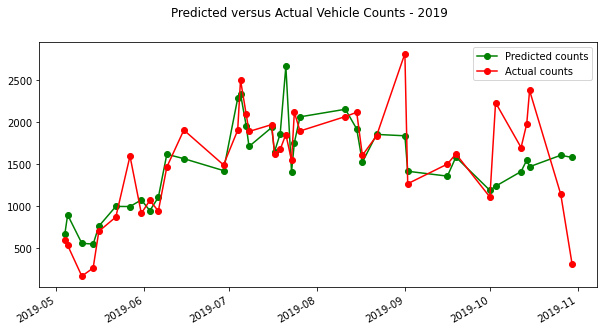

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2019]
actual_counts = actual_counts[actual_counts.index.year==2019]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2019')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

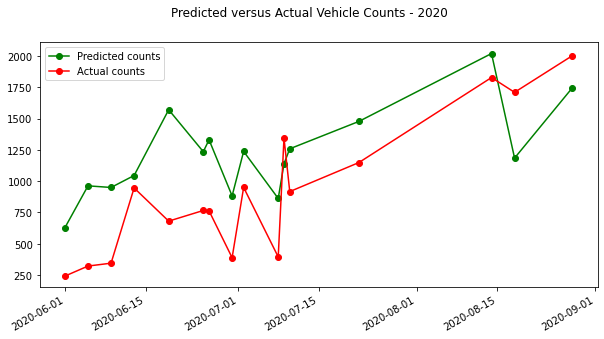

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2020]
actual_counts = actual_counts[actual_counts.index.year==2020]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2020')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

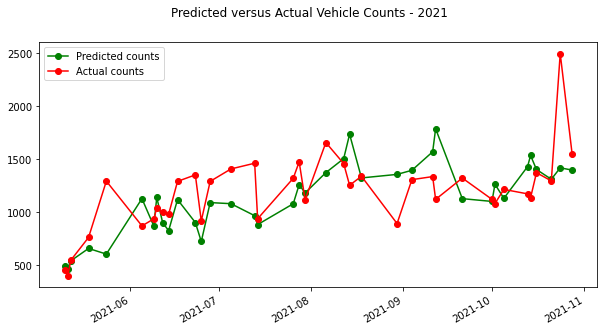

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2021]
actual_counts = actual_counts[actual_counts.index.year==2021]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2021')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

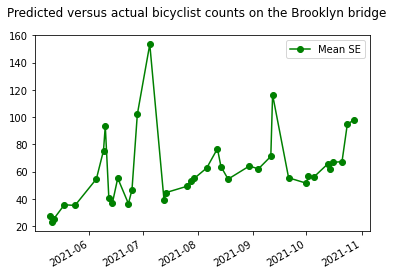

In [ ]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2021]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

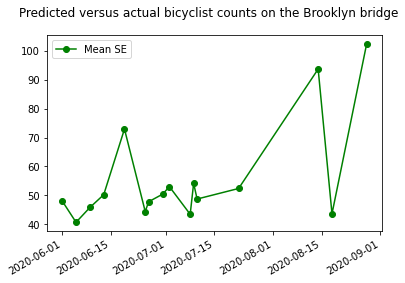

In [ ]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2020]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

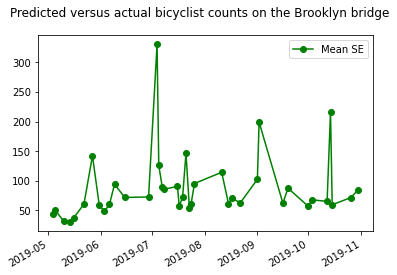

In [ ]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2019]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

In [ ]:
from statsmodels.tools.eval_measures import rmse
rmse = rmse(y_test, predictions_summary_frame['mean'])

<Figure size 432x288 with 0 Axes>

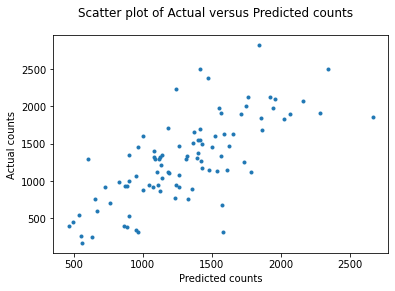

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()